<a href="https://colab.research.google.com/github/federicobrancasi/Test-Time-Adaptation-for-Image-Classification/blob/main/TTA%20Image%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Project

## Download Datasets

In [1]:
# download datasets from a shared folder in google drive
!gdown 1-m3lAmp63chP_9kFZjAd5iNTCsck6yA1 # id for imagenet-a
!gdown 1wbmp6PsLiECc4lrKdut1bB2avTKcFPhd # id for imagenetv2

# unzip them!
!tar -xf imagenet-a.tar
!tar -xf imagenetv2-matched-frequency.tar.gz

!ls

Downloading...
From (original): https://drive.google.com/uc?id=1-m3lAmp63chP_9kFZjAd5iNTCsck6yA1
From (redirected): https://drive.google.com/uc?id=1-m3lAmp63chP_9kFZjAd5iNTCsck6yA1&confirm=t&uuid=6b5ef78c-51a3-4dc6-ac88-f4624aef25d7
To: /content/imagenet-a.tar
100% 688M/688M [00:07<00:00, 96.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1wbmp6PsLiECc4lrKdut1bB2avTKcFPhd
From (redirected): https://drive.google.com/uc?id=1wbmp6PsLiECc4lrKdut1bB2avTKcFPhd&confirm=t&uuid=0c2ea15e-c2b0-4ca9-8865-f9ae603d93a7
To: /content/imagenetv2-matched-frequency.tar.gz
100% 1.26G/1.26G [00:13<00:00, 96.8MB/s]
imagenet-a	imagenetv2-matched-frequency-format-val  sample_data
imagenet-a.tar	imagenetv2-matched-frequency.tar.gz


## Import Needed Libraries

In [2]:
# import libraries
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Create Dataloader

In [3]:
# dataloader
"""
Input arguments:
  batch_size: mini batch size used during training
  img_root: path to the dataset parent folder.
            The folder just above the sub-folders or class folders
"""

def get_data(batch_size, img_root):
  # prepare data transformations for the train loader
  transform = list()
  transform.append(T.Resize((256, 256)))                      # resize each PIL image to 256 x 256
  # transform.append(T.RandomCrop((224, 224)))                  # randomly crop a 224 x 224 patch
  transform.append(T.ToTensor())                              # convert Numpy to Pytorch Tensor
  # transform.append(T.Normalize(mean=[0.485, 0.456, 0.406],
  #                              std=[0.229, 0.224, 0.225]))    # normalize with ImageNet mean
  transform = T.Compose(transform)                            # compose the above transformations into one

  # load data
  dataset = torchvision.datasets.ImageFolder(root=img_root, transform=transform)

  # create train and test splits (80/20)
  num_samples = len(dataset)
  training_samples = int(num_samples * 0.8 + 1)
  test_samples = num_samples - training_samples

  training_data, test_data = torch.utils.data.random_split(dataset,
                                                           [training_samples, test_samples])

  # initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False)

  return train_loader, test_loader

In [4]:
train_loader_imageneta, test_loader_imageneta = get_data(batch_size=128, img_root='/content/imagenet-a')
train_loader_imagenetv2, test_loader_imagenetv2 = get_data(batch_size=128, img_root='/content/imagenetv2-matched-frequency-format-val')

In [5]:
print("imagenet-a dataloader: ")
for X, y in test_loader_imageneta:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

print("\nimagenetv2 dataloader: ")
for X, y in test_loader_imagenetv2:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

imagenet-a dataloader: 
Shape of X [N, C, H, W]: torch.Size([128, 3, 256, 256])
Shape of y: torch.Size([128]) torch.int64

imagenetv2 dataloader: 
Shape of X [N, C, H, W]: torch.Size([128, 3, 256, 256])
Shape of y: torch.Size([128]) torch.int64


# Check Device

In [6]:
# get cuda device
if torch.cuda.is_available():
  device = "cuda"

print(f"Using {device} device")

Using cuda device


## Show some images from both Datasets

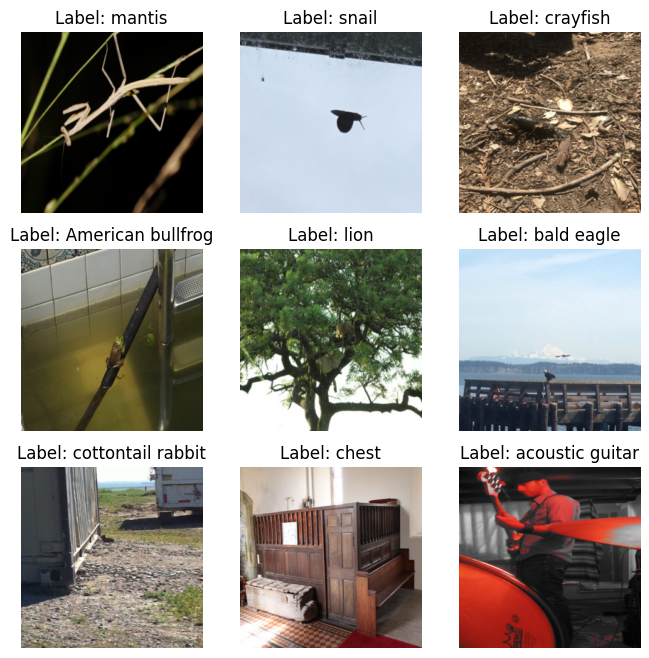

In [7]:
# show some imagenet-a images 😁

# label map for imagenet-a
label_map = {
    0: "stingray", 1: "goldfinch", 2: "junco", 3: "American robin", 4: "jay", 5: "bald eagle", 6: "vulture", 7: "newt", 8: "American bullfrog", 9: "box turtle", 10: "green iguana",
    11: "agama", 12: "chameleon", 13: "American alligator", 14: "garter snake", 15: "harvestman", 16: "scorpion", 17: "tarantula", 18: "centipede", 19: "sulphur-crested cockatoo",
    20: "lorikeet", 21: "hummingbird", 22: "toucan", 23: "duck", 24: "goose", 25: "koala", 26: "jellyfish", 27: "sea anemone", 28: "flatworm", 29: "snail", 30: "crayfish",
    31: "hermit crab", 32: "flamingo", 33: "great egret", 34: "oystercatcher", 35: "pelican", 36: "sea lion", 37: "Chihuahua", 38: "Golden Retriever", 39: "Rottweiler",
    40: "German Shepherd Dog", 41: "pug", 42: "red fox", 43: "Persian cat", 44: "lynx", 45: "lion", 46: "American black bear", 47: "mongoose", 48: "ladybug", 49: "rhinoceros beetle",
    50: "weevil", 51: "fly", 52: "bee", 53: "ant", 54: "grasshopper", 55: "stick insect", 56: "cockroach", 57: "mantis", 58: "leafhopper", 59: "dragonfly", 60: "monarch butterfly",
    61: "small white", 62: "gossamer-winged butterfly", 63: "starfish", 64: "cottontail rabbit", 65: "porcupine", 66: "fox squirrel", 67: "marmot", 68: "bison", 69: "skunk", 70: "armadillo",
    71: "baboon", 72: "white-headed capuchin", 73: "African bush elephant", 74: "pufferfish", 75: "academic gown", 76: "accordion", 77: "acoustic guitar", 78: "airliner", 79: "ambulance",
    80: "apron", 81: "balance beam", 82: "balloon", 83: "banjo", 84: "barn", 85: "wheelbarrow", 86: "basketball", 87: "lighthouse", 88: "beaker", 89: "bikini", 90: "bow", 91: "bow tie",
    92: "breastplate", 93: "broom", 94: "candle", 95: "canoe", 96: "castle", 97: "cello", 98: "chain", 99: "chest", 100: "Christmas stocking", 101: "cowboy boot", 102: "cradle", 103: "rotary dial telephone",
    104: "digital clock", 105: "doormat", 106: "drumstick", 107: "dumbbell", 108: "envelope", 109: "feather boa", 110: "flagpole", 111: "forklift", 112: "fountain", 113: "garbage truck",
    114: "goblet", 115: "go-kart", 116: "golf cart", 117: "grand piano", 118: "hair dryer", 119: "clothes iron", 120: "jack-o'-lantern", 121: "jeep", 122: "kimono", 123: "lighter",
    124: "limousine", 125: "manhole cover", 126: "maraca", 127: "marimba", 128: "mask", 129: "mitten", 130: "mosque", 131: "nail", 132: "obelisk", 133: "ocarina", 134: "organ", 135: "parachute",
    136: "parking meter", 137: "piggy bank", 138: "billiard table", 139: "hockey puck", 140: "quill", 141: "racket", 142: "reel", 143: "revolver", 144: "rocking chair", 145: "rugby ball",
    146: "salt shaker", 147: "sandal", 148: "saxophone", 149: "school bus", 150: "schooner", 151: "sewing machine", 152: "shovel", 153: "sleeping bag", 154: "snowmobile", 155: "snowplow",
    156: "soap dispenser", 157: "spatula", 158: "spider web", 159: "steam locomotive", 160: "stethoscope", 161: "couch", 162: "submarine", 163: "sundial", 164: "suspension bridge", 165: "syringe",
    166: "tank", 167: "teddy bear", 168: "toaster", 169: "torch", 170: "tricycle", 171: "umbrella", 172: "unicycle", 173: "viaduct", 174: "volleyball", 175: "washing machine", 176: "water tower",
    177: "wine bottle", 178: "shipwreck", 179: "guacamole", 180: "pretzel", 181: "cheeseburger", 182: "hot dog", 183: "broccoli", 184: "cucumber", 185: "bell pepper", 186: "mushroom",
    187: "lemon", 188: "banana", 189: "custard apple", 190: "pomegranate", 191: "carbonara", 192: "bubble", 193: "cliff", 194: "volcano", 195: "baseball player", 196: "rapeseed",
    197: "yellow lady's slipper", 198: "corn", 199: "acorn"
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Iterate over batches loaded from the DataLoader
for batch_idx, (data, labels) in enumerate(train_loader_imageneta, 1):
    # Iterate over data within the batch
    for img_idx, (img, label) in enumerate(zip(data, labels), 1):
        # Add subplot to the figure
        subplot_idx = (batch_idx - 1) * len(data) + img_idx
        if subplot_idx > cols * rows:
            break

        figure.add_subplot(rows, cols, subplot_idx)

        # Display the image and the label
        plt.title(f"Label: {label_map[label.item()]}")  # Display the label as title using the label map
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0))  # Permute dimensions to fit matplotlib format

    # If enough subplots have been displayed, exit the outer loop
    if batch_idx * len(data) >= cols * rows:
        break

plt.show()

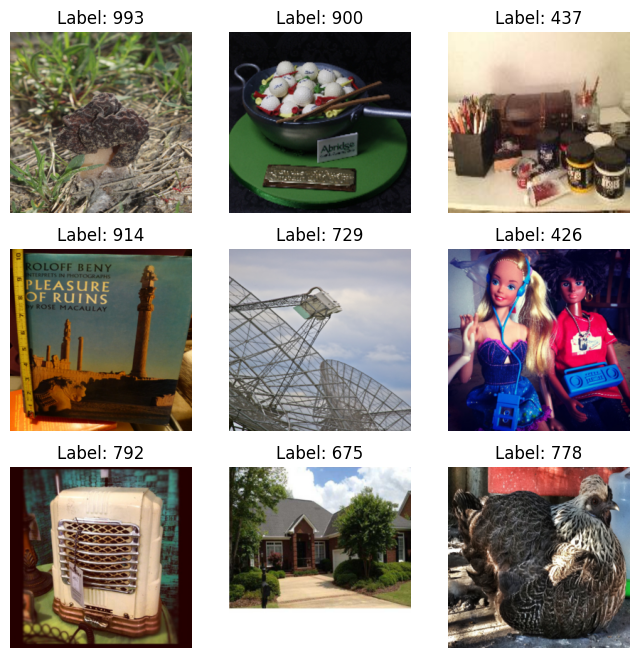

In [8]:
# show some imagenet-v2 images (no labelmap, because we have 1000 labels 😐)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Iterate over batches loaded from the DataLoader
for batch_idx, (data, labels) in enumerate(train_loader_imagenetv2, 1):
    # Iterate over data within the batch
    for img_idx, (img, label) in enumerate(zip(data, labels), 1):
        # Add subplot to the figure
        subplot_idx = (batch_idx - 1) * len(data) + img_idx
        if subplot_idx > cols * rows:
            break

        figure.add_subplot(rows, cols, subplot_idx)

        # Display the image and the label
        plt.title(f"Label: {label.item()}")  # Display the label as title
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0))  # Permute dimensions to fit matplotlib format

    # If enough subplots have been displayed, exit the outer loop
    if batch_idx * len(data) >= cols * rows:
        break

plt.show()